In [1]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

In [2]:
sqlCte = SparkSession.builder.getOrCreate()

In [3]:
boston_housing = sqlCte.read.option('header', 'true').csv('BostonHousing.csv', inferSchema=True)
boston_housing.show()
print(boston_housing.dtypes)

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

<Axes: >

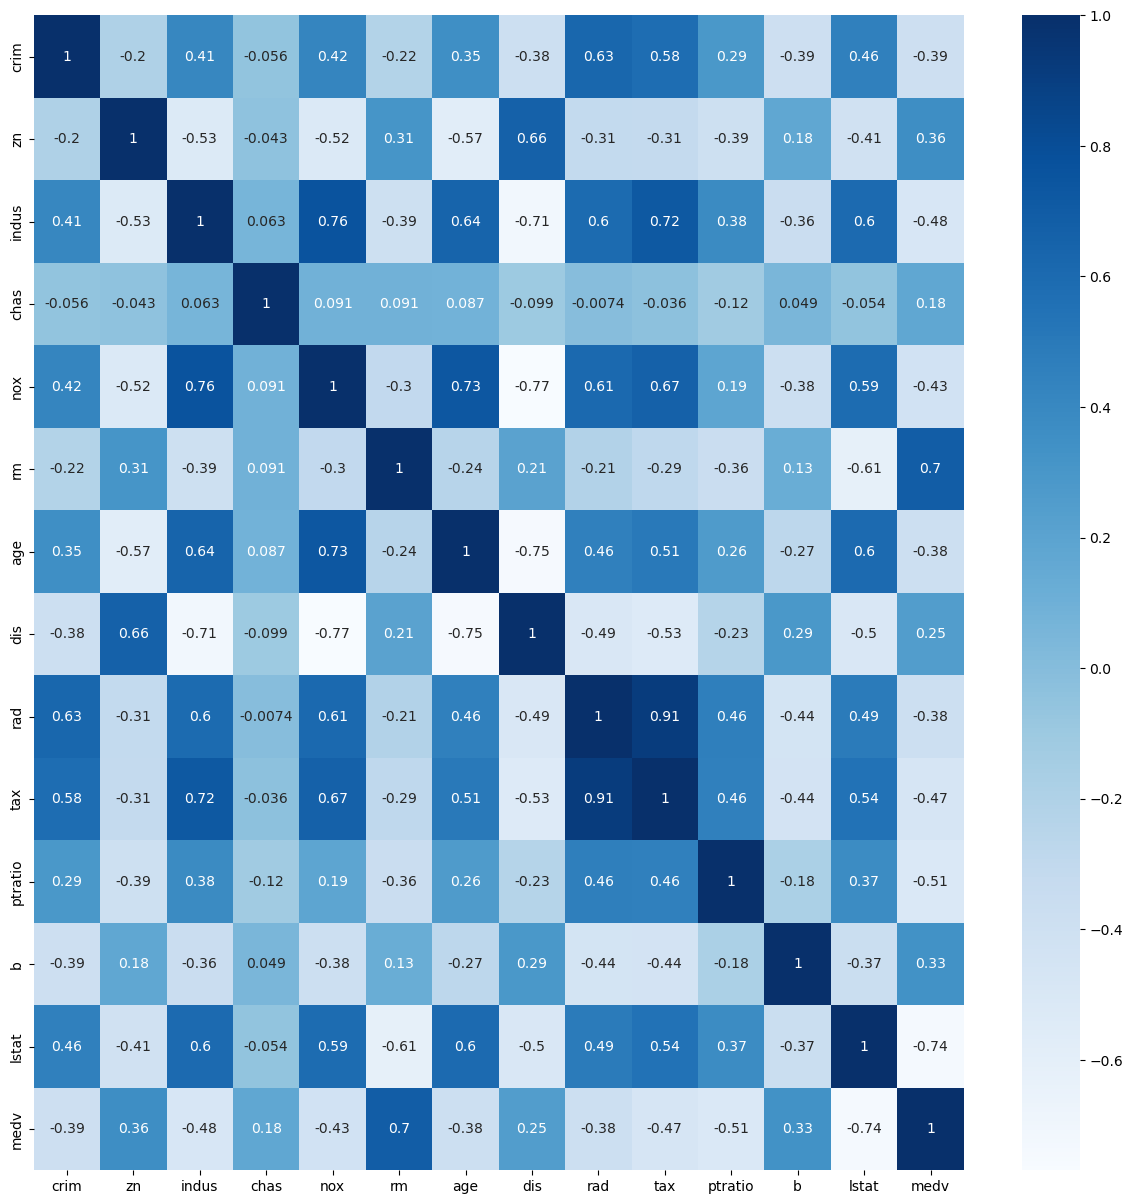

In [4]:
boston_housing_pandas_dataframe=boston_housing.toPandas()
fig, ax =plt.subplots(figsize = (15,15))

sb.heatmap(boston_housing_pandas_dataframe.corr(), cmap='Blues', annot = True, ax= ax)

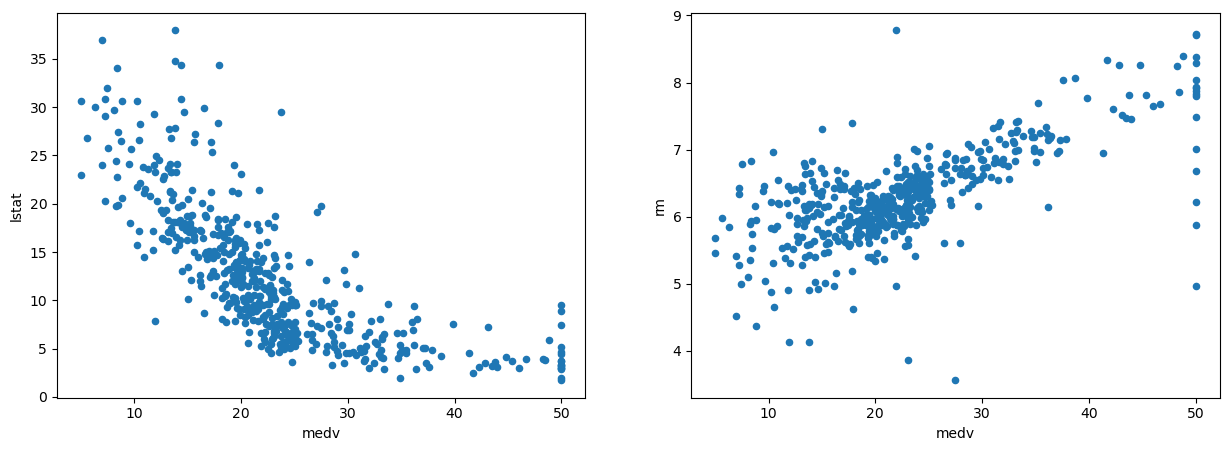

In [5]:
# Before we see that the variables with higher correlation are 'lstat' and 'rm'
#Then let to representive them in scatter graphs
fig, ax = plt.subplots(1, 2, figsize=(15,5))

boston_housing_pandas_dataframe.plot.scatter(x='medv', y='lstat', ax=ax[0])
boston_housing_pandas_dataframe.plot.scatter(x='medv', y='rm', ax=ax[1])

plt.show()

Create a regression model using a ploynomian function of degree two on the three selected variable

Use 70% of the data for training:

y= a*x^2 + bx +C

In [8]:
# firstly, creata the attributes of the equation
boston_housing = boston_housing.withColumn('lstat2', col('lstat')*col('lstat'))
boston_housing = boston_housing.withColumn('rm2', col('rm')*col('rm'))

rmassembler = VectorAssembler(inputCols=['rm','rm2'], outputCol='rmfeatures')
lstatassembler = VectorAssembler(inputCols=['lstat', 'lstat2'], outputCol='lstatfeatures')


df_rm=rmassembler.transform(boston_housing).select(['medv', 'rmfeatures'])
df_lstat=lstatassembler.transform(boston_housing).select(['medv', 'lstatfeatures'])
df_rm.show()
df_lstat.show()
df_training_lstat, df_test_lstat = df_lstat.randomSplit([0.7,0.3])
df_training_rm, df_test_rm = df_rm.randomSplit([0.7,0.3])

+----+--------------------+
|medv|          rmfeatures|
+----+--------------------+
|24.0|   [6.575,43.230625]|
|21.6|   [6.421,41.229241]|
|34.7|[7.185,51.6242249...|
|33.4|[6.998,48.9720040...|
|36.2|[7.147,51.0796090...|
|28.7|[6.43,41.34489999...|
|22.9|   [6.012,36.144144]|
|27.1|   [6.172,38.093584]|
|16.5|[5.631,31.7081610...|
|18.9|   [6.004,36.048016]|
|15.0|   [6.377,40.666129]|
|18.9|[6.009,36.1080810...|
|21.7|   [5.889,34.680321]|
|20.4|   [5.949,35.390601]|
|18.2|   [6.096,37.161216]|
|19.9|[5.834,34.0355559...|
|23.1|   [5.935,35.224225]|
|17.5|[5.99,35.88010000...|
|20.2|[5.456,29.7679360...|
|18.2|   [5.727,32.798529]|
+----+--------------------+
only showing top 20 rows

+----+--------------------+
|medv|       lstatfeatures|
+----+--------------------+
|24.0|[4.98,24.80040000...|
|21.6|[9.14,83.53960000...|
|34.7|[4.03,16.24090000...|
|33.4|       [2.94,8.6436]|
|36.2|      [5.33,28.4089]|
|28.7|[5.21,27.14409999...|
|22.9|    [12.43,154.5049]|
|27.1|[19.15,366.72249

In [7]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [9]:
#Fit the model
pr = LinearRegression(featuresCol='lstatfeatures', labelCol='medv', maxIter=30)

prModel = pr.fit(df_training_lstat)

print('Coefficetn:' + str(prModel.coefficients))
print('Intercept:' + str(prModel.intercept))

#r2 shows the accuracy of our model

print('r2:', prModel.summary.r2)

Coefficetn:[-2.3766045123726838,0.044984475213466754]
Intercept:43.081877041436016
r2: 0.6481894130896342


In [10]:
import numpy as np
from matplotlib import pyplot as plt

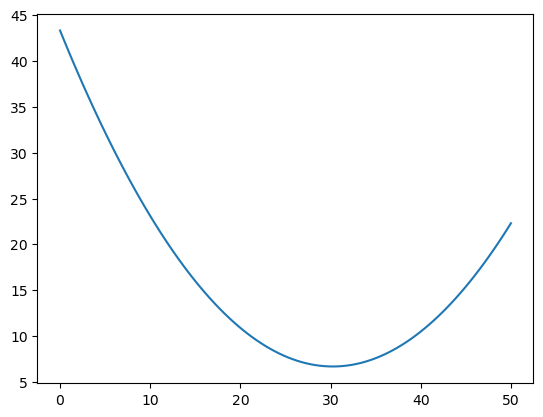

In [11]:
# I will create a range of 0-50 that is value of MEDV with 100 data

x= np.linspace(0,50,100)

#now we create empty array of fx

fx=[]

#for each value on the x (MEDV) we made a Y value

for i in range(len(x)):
    fx.append(0.04*x[i]*x[i] - 2.42*x[i] + 43.31)
    
plt.plot(x,fx)
plt.show()


#ax^2 +bx +c, a here is 0.04 b is -2.42, c is 43.31

In [12]:
pr=prModel.transform(df_test_lstat)
#evaluate the model using R-squared metric
evaluator=RegressionEvaluator(labelCol='medv', predictionCol='prediction', metricName='r2')

r2=evaluator.evaluate(pr)
print('R-squares on test data : %.3f' %r2)

R-squares on test data : 0.623
